# 合成コントロール法

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import gpboost as gpb
from patsy import dmatrices, dmatrix
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
path = '../../../../data/raw/df.xlsx'
df = pd.read_excel(path)

path = '../../../../data/processed/scm_df_treatment_group_pre.xlsx'
pre_treat = pd.read_excel(path, index_col=0)

path = '../../../../data/processed/scm_df_treatment_group.xlsx'
all_treat = pd.read_excel(path, index_col=0)

path = '../../../../data/processed/scm_df_control_group.xlsx'
control_df = pd.read_excel(path, index_col=0)

In [134]:
pre_treat.shape, all_treat.shape, control_df.shape

((29, 39), (29, 53), (29, 105))

In [139]:
pre_treat.columns

Index(['66', '67', '68', '70', '72', '88', '94', '95', '103', '104', '106',
       '108', '109', '112', '113', '117', '118', '125', '130', '132', '145',
       '146', '156', '157', '160', '171', '172', '173', '187', '188', '189',
       '192', '193', '195', '197', '202', '216', '221', '223'],
      dtype='object')

In [136]:
all_treat.head()

,66,67,68,70,72,88,89,91,92,94,...,192,193,195,197,202,204,216,221,223,226
year,,,,,,,,,,,,,,,,,,,,,
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.181784,7.098376,NaN
1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.170484,7.078342,NaN
1970,8.405144,NaN,4.077537,6.956545,NaN,7.984463,7.909122,NaN,NaN,9.307467,...,9.606563,9.213136,9.415401,7.346010,4.343805,7.026427,7.855545,4.983607,6.971669,NaN
1975,8.427050,NaN,3.828641,6.729824,NaN,7.843456,7.784889,NaN,NaN,9.459464,...,9.508443,9.290537,9.372289,7.172425,4.304065,6.814543,7.780721,4.912655,6.981006,NaN
1980,8.301522,NaN,3.951244,6.660575,NaN,7.787797,7.694393,NaN,NaN,9.457903,...,9.424564,9.249176,9.309280,7.060476,4.025352,6.682109,7.688455,4.890349,6.920672,6.641182


In [44]:
control_df.head()

,62,63,64,65,69,71,73,76,77,78,...,212,213,214,215,217,218,219,220,224,225
year,,,,,,,,,,,,,,,,,,,,,
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.765569,6.086775
1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.476472,5.837730
1970,9.958118,8.429236,8.576405,7.180831,5.899897,5.214936,NaN,6.139885,5.493061,3.951244,...,7.115582,6.552508,5.613128,6.946014,6.042633,6.850126,6.800170,4.927254,6.988413,5.556828
1975,9.900383,8.261785,8.527539,7.026427,5.814131,4.330733,NaN,5.843544,5.318120,3.912023,...,6.975414,6.333280,5.099866,6.799056,5.579730,6.673298,6.493754,4.795791,6.770789,5.442418
1980,9.908525,8.194782,8.547528,7.009409,5.560682,4.204693,NaN,5.537334,5.257495,3.912023,...,6.873164,6.192362,4.859812,6.715383,5.433722,6.620073,6.467699,4.663439,6.551080,5.288267


[1.870e-02 2.000e-04 2.400e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 6.340e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.600e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 6.814e-01 0.000e+00 5.240e-02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 7.750e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.070e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.860e-02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

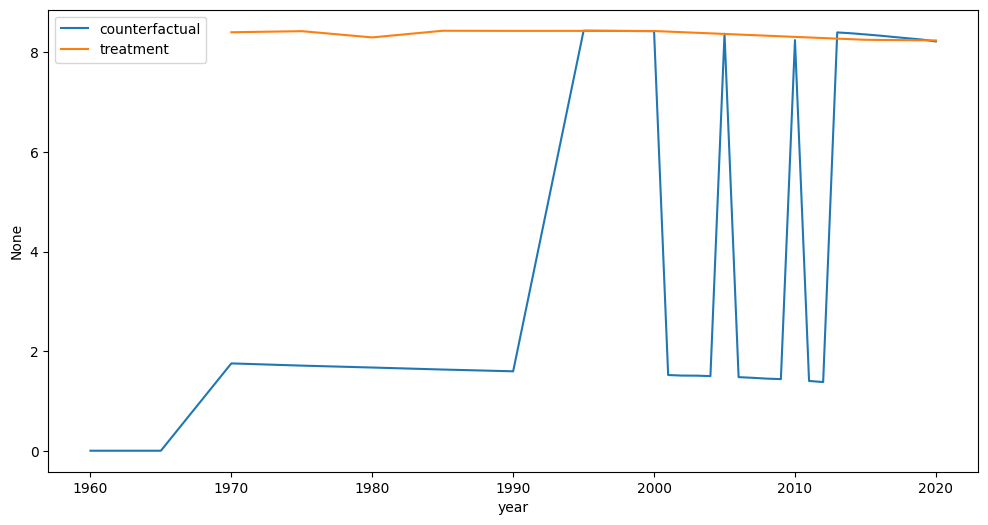

[0.0389 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.1191 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082 0.0082
 0.0082 0.0082 0.0082 0.0082 0.0082]
1.0000000000076228


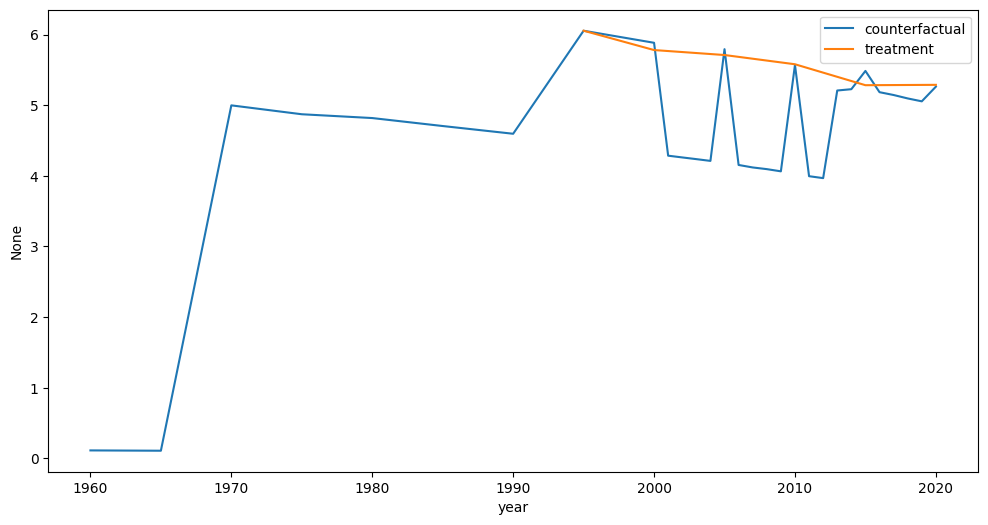

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.5998
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.4002 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.    ]
1.000000000000003


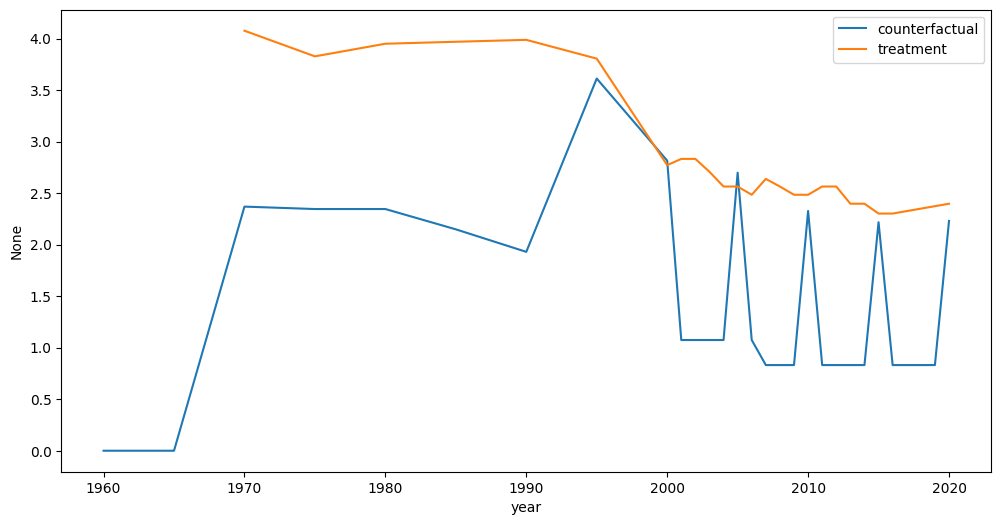

[0.0325 0.0078 0.0078 0.0078 0.0078 0.0077 0.0075 0.0077 0.0078 0.0063
 0.008  0.0076 0.0077 0.0073 0.0076 0.0078 0.0076 0.0077 0.0077 0.0076
 0.0077 0.0077 0.0074 0.0072 0.0074 0.0077 0.0077 0.008  0.0076 0.0073
 0.0077 0.0079 0.0077 0.0078 0.0077 0.0078 0.0078 0.0076 0.0073 0.0078
 0.0078 0.0076 0.0076 0.0076 0.0083 0.0079 0.0075 0.0076 0.0079 0.0077
 0.0076 0.0078 0.0076 0.0077 0.0077 0.0077 0.0077 0.1759 0.0079 0.0083
 0.0077 0.0077 0.008  0.0074 0.0083 0.0078 0.0075 0.0069 0.0077 0.0075
 0.0075 0.0076 0.0077 0.0077 0.0076 0.0076 0.0073 0.0077 0.0079 0.0082
 0.0078 0.0077 0.0077 0.0078 0.0078 0.0076 0.008  0.0077 0.0075 0.0076
 0.0083 0.0078 0.0077 0.0077 0.0077 0.0077 0.0077 0.0077 0.0076 0.0078
 0.0078 0.0078 0.0075 0.0076 0.0079]
1.0000000000000002


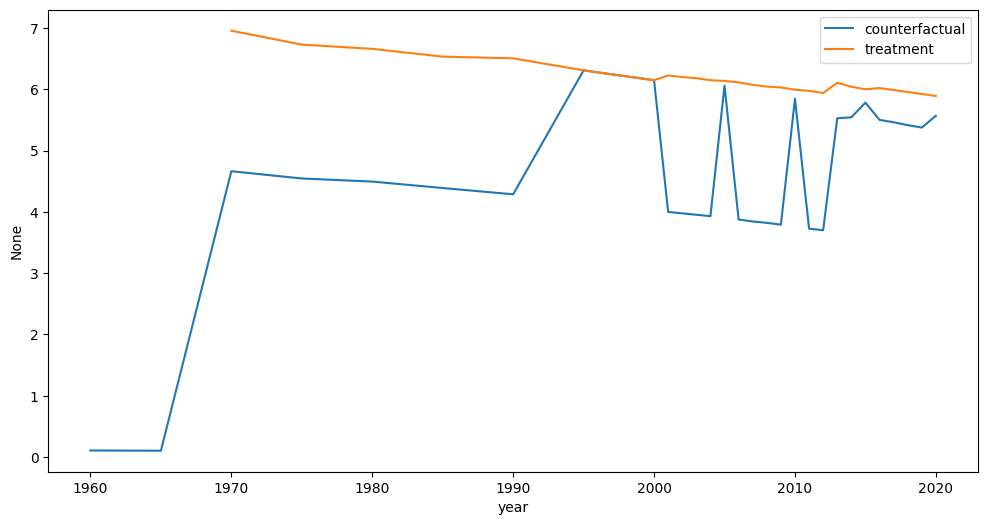

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


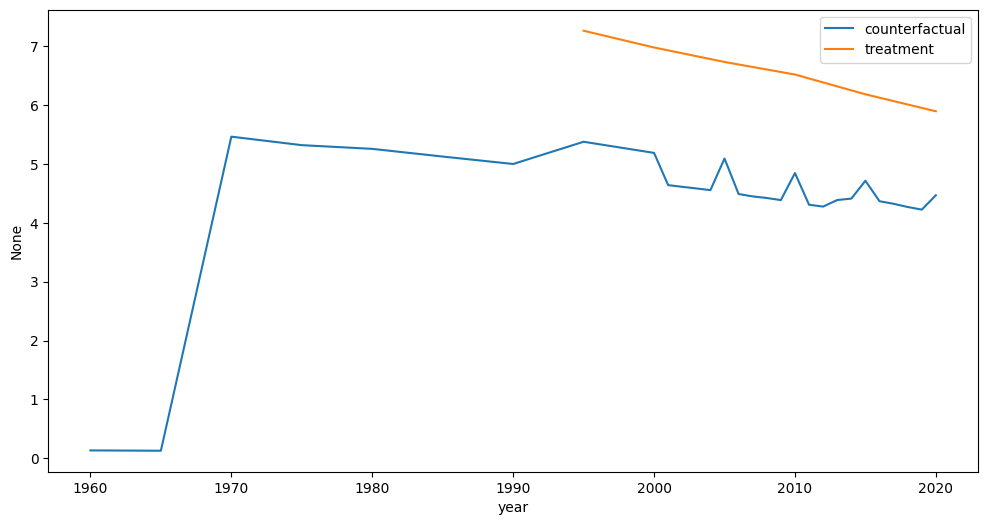

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


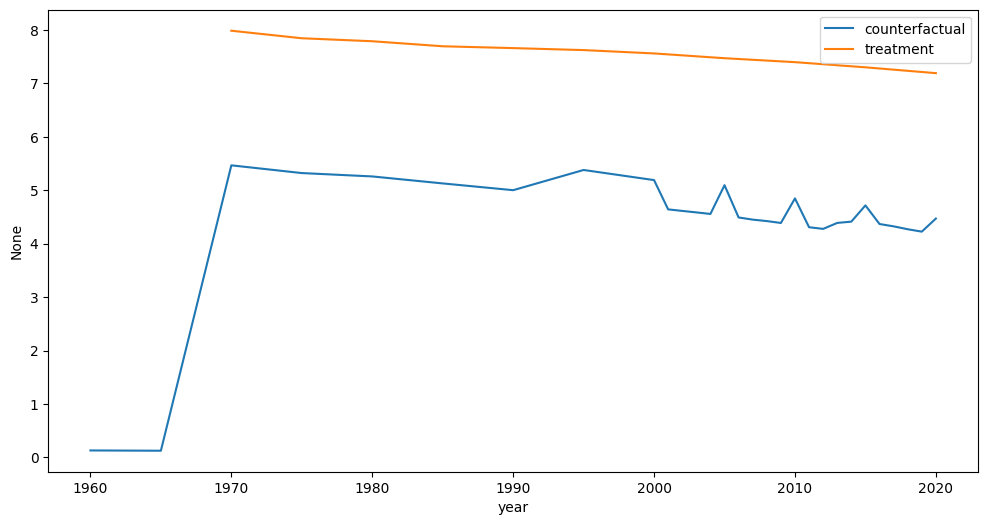

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


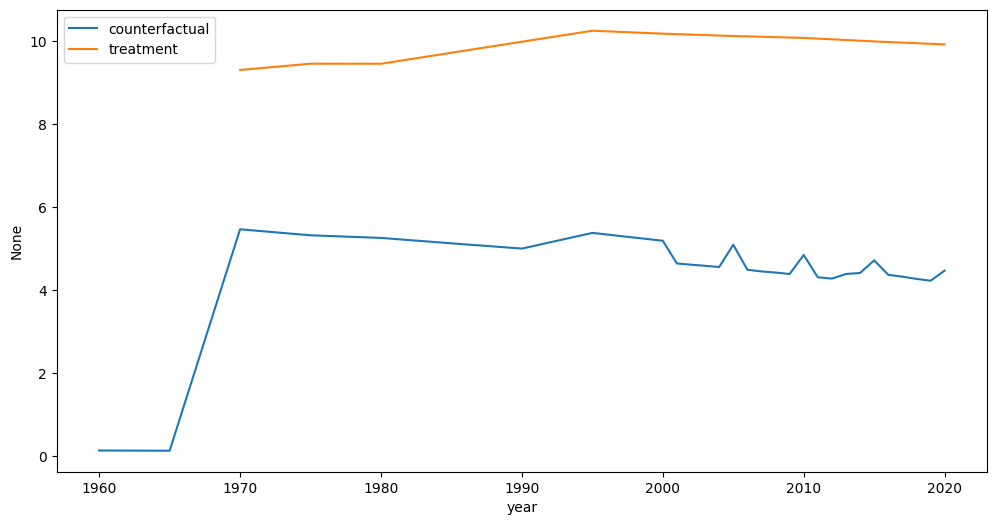

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


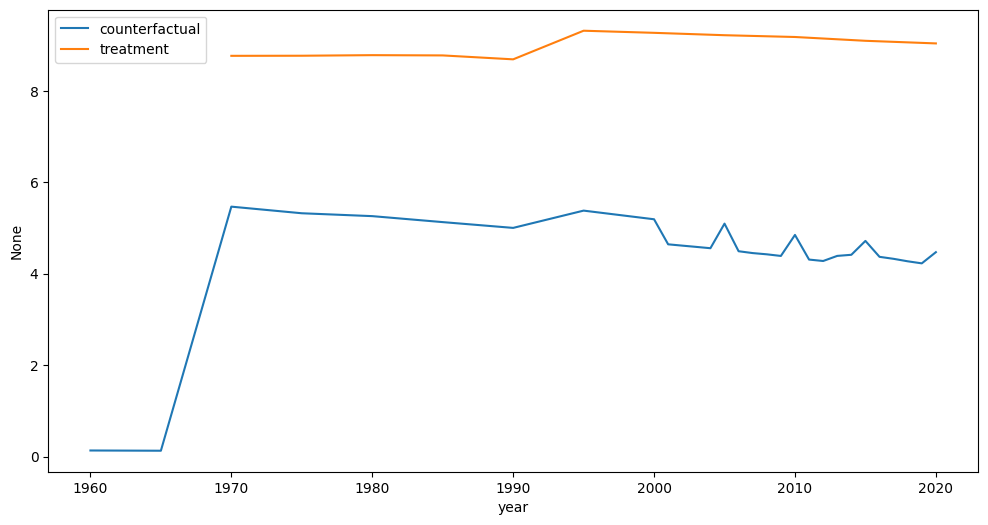

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


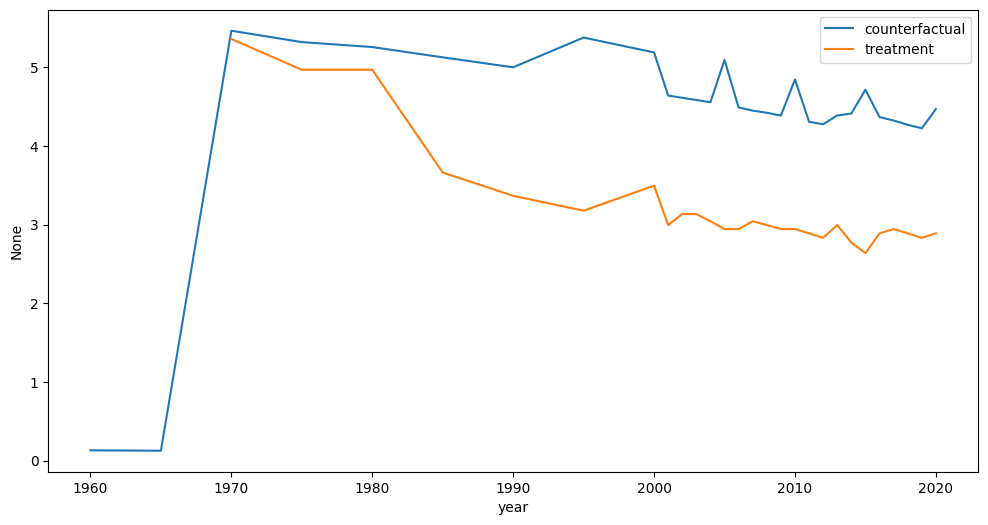

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


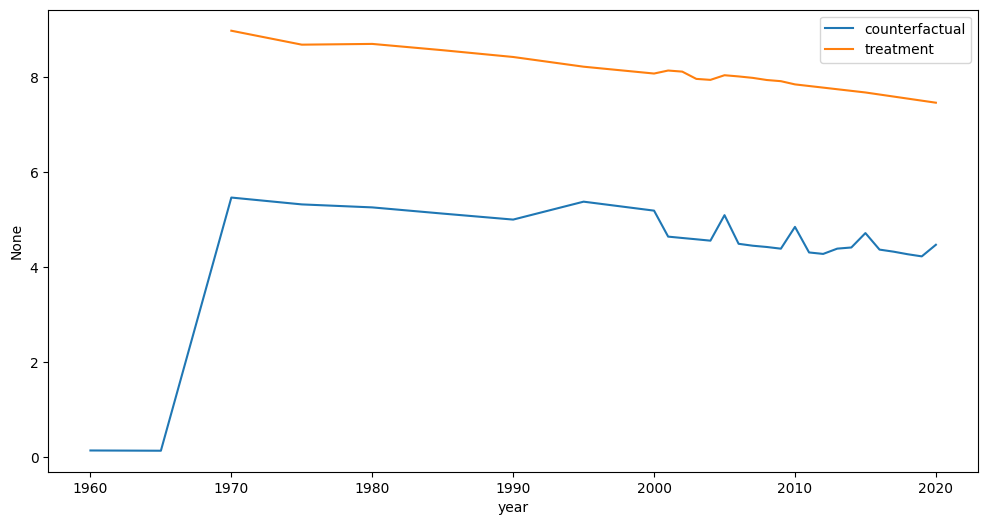

[0.0046 0.0045 0.0046 0.0048 0.0048 0.0051 0.0058 0.0051 0.0047 0.0127
 0.0033 0.0058 0.0052 0.0068 0.0055 0.0049 0.0057 0.0048 0.0052 0.0055
 0.0052 0.0051 0.0059 0.0073 0.0057 0.0049 0.005  0.0033 0.0055 0.0074
 0.0049 0.0043 0.0051 0.0047 0.0051 0.0046 0.0043 0.0062 0.0067 0.0046
 0.0045 0.0053 0.0056 0.0053 0.0019 0.004  0.0059 0.0053 0.0041 0.0052
 0.0054 0.0042 0.0056 0.005  0.0048 0.0049 0.0048 0.4756 0.0041 0.0021
 0.0048 0.005  0.0037 0.0065 0.0019 0.0047 0.0057 0.0093 0.0048 0.0063
 0.0058 0.0052 0.005  0.0049 0.0053 0.0057 0.0069 0.0049 0.004  0.0024
 0.0047 0.0042 0.0048 0.0042 0.0043 0.0053 0.0035 0.0051 0.0057 0.0052
 0.0022 0.0047 0.005  0.0051 0.0049 0.0049 0.0051 0.0049 0.0052 0.0043
 0.0048 0.0045 0.0062 0.0056 0.0045]
1.0


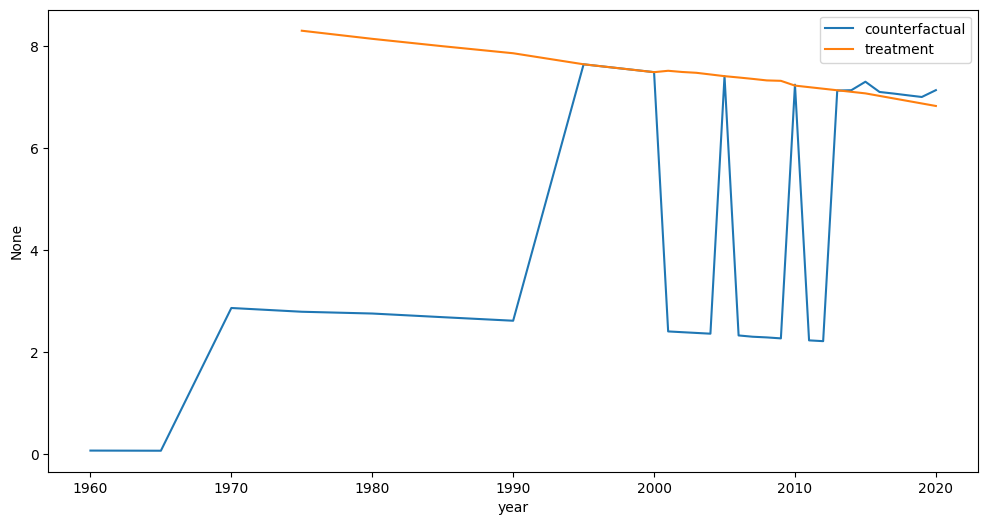

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


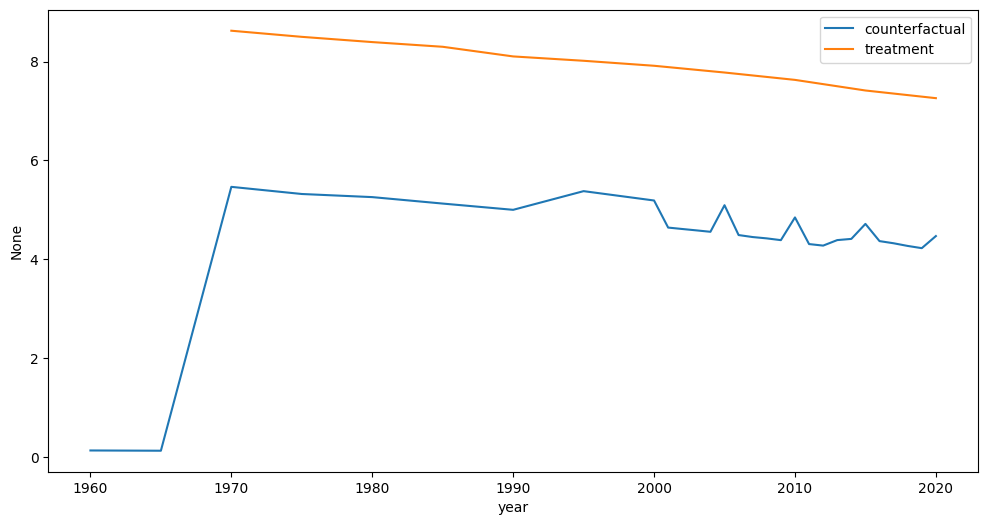

[0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.5591 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042 0.0042
 0.0042 0.0042 0.0042 0.0042 0.0042]
1.0000000009199717


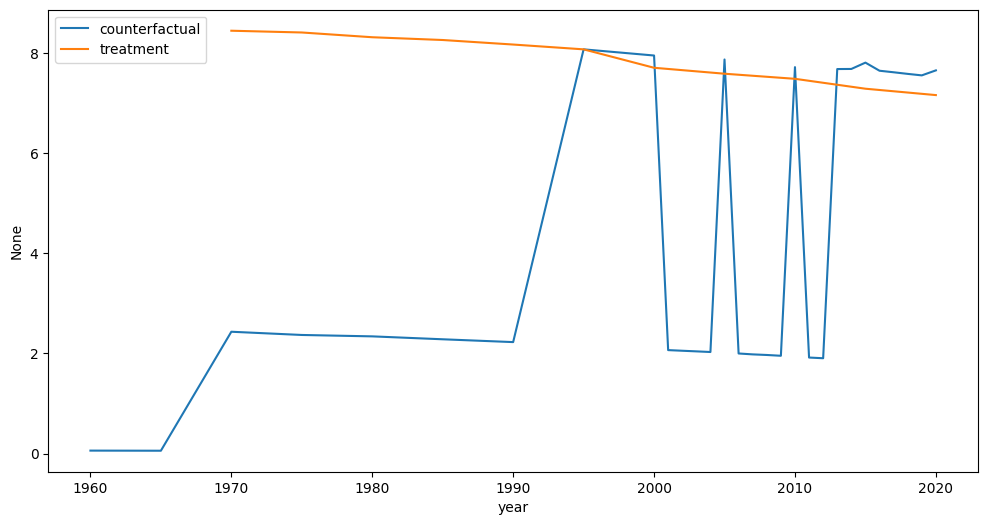

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


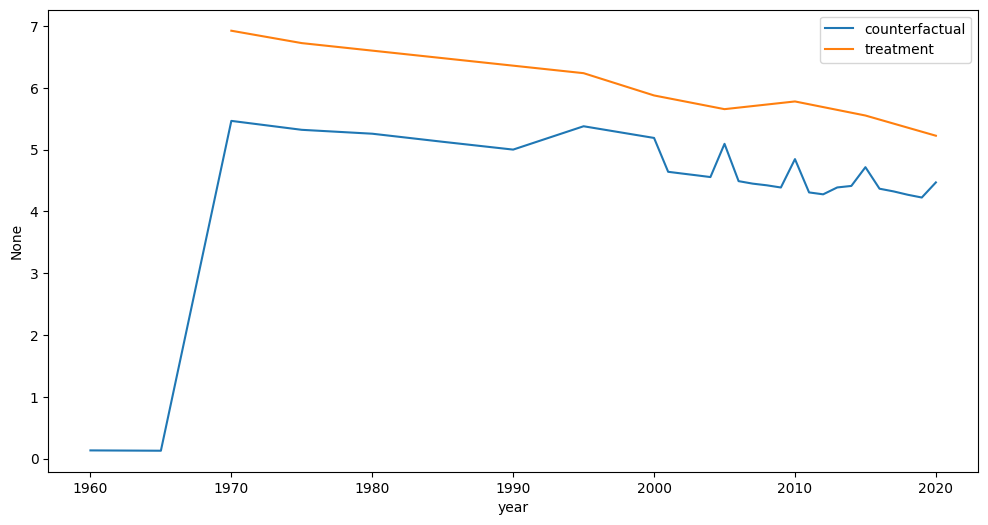

[0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0184
 0.017  0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0111
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0144 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0144 0.0089 0.0089 0.0089 0.0089 0.0089 0.017
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0319 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089 0.0089
 0.0089 0.0089 0.0089 0.0089 0.0089]
0.9999999999999997


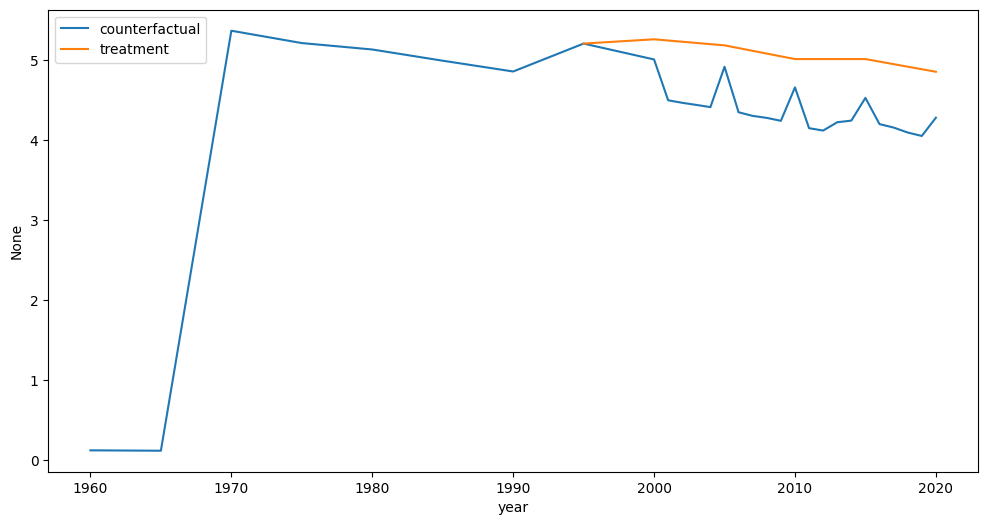

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


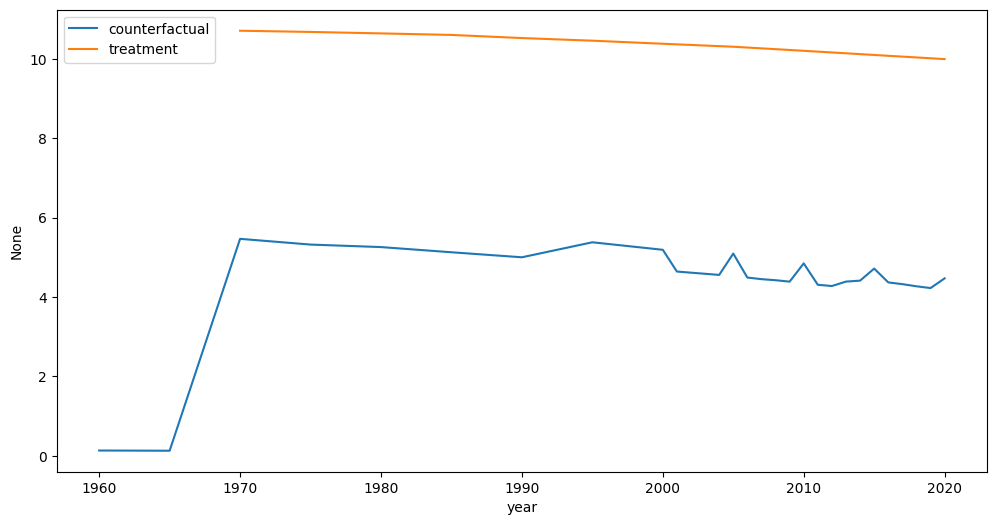

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


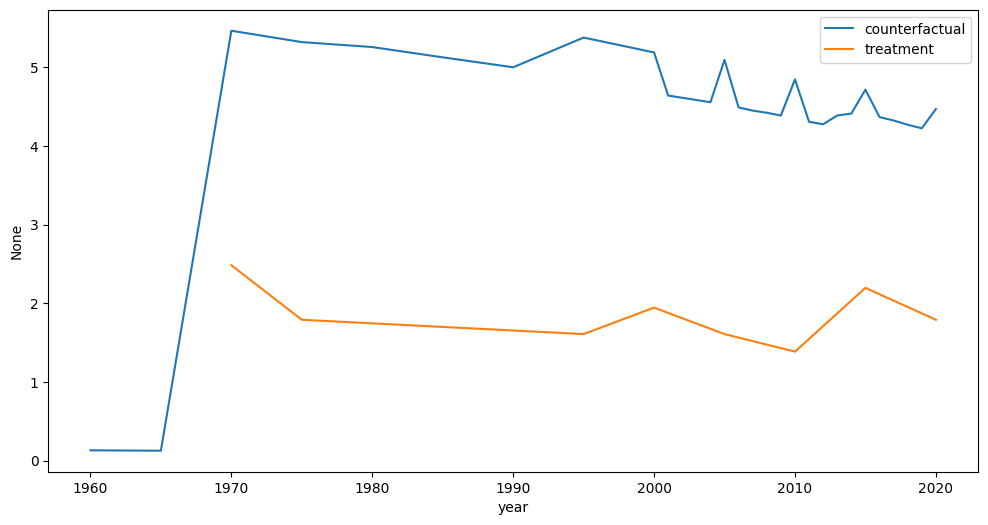

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


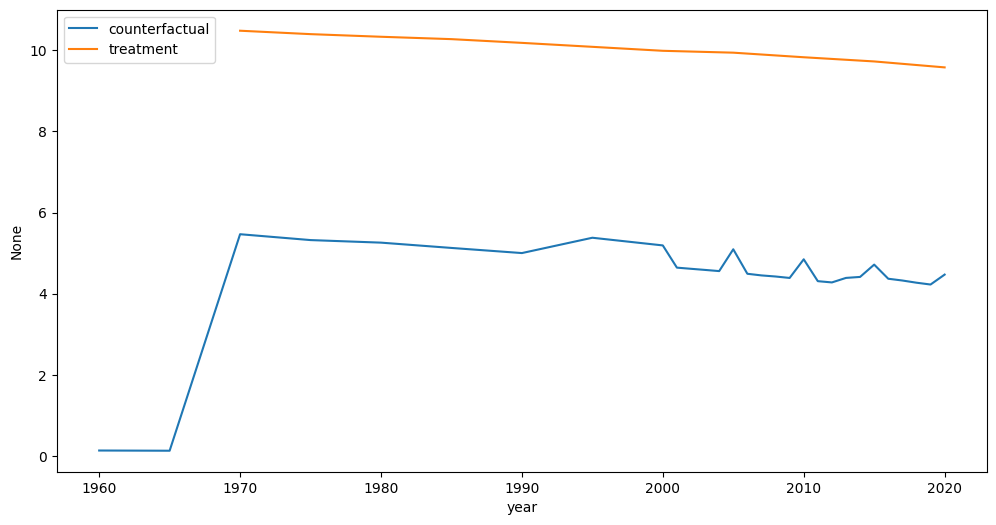

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


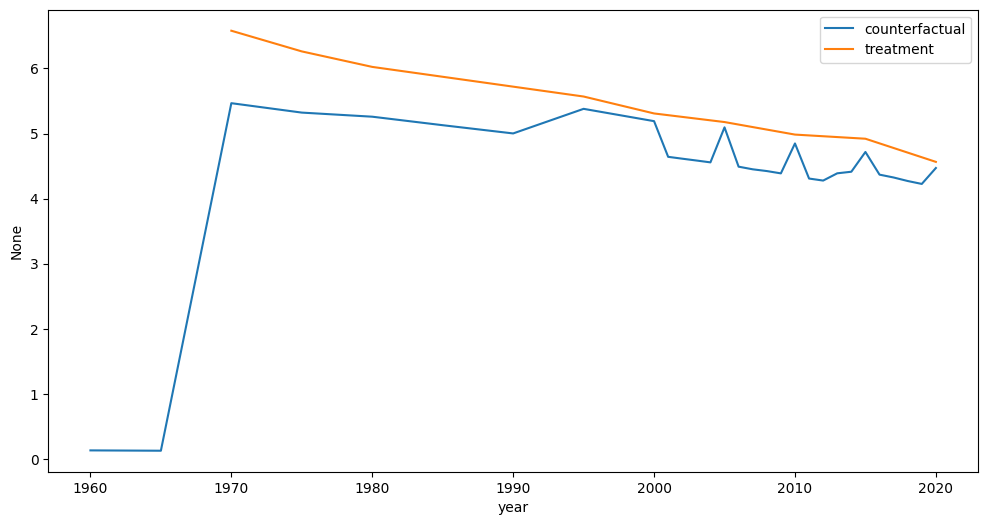

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


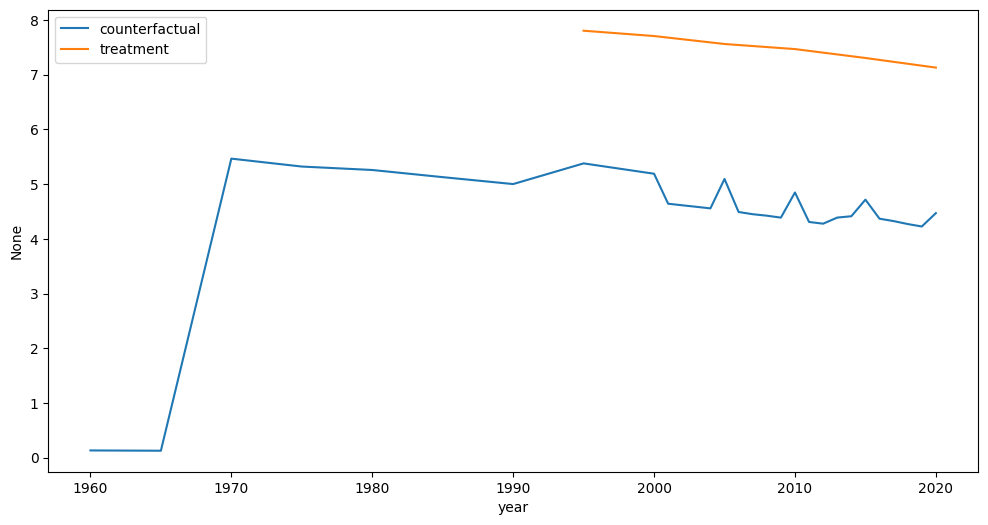

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


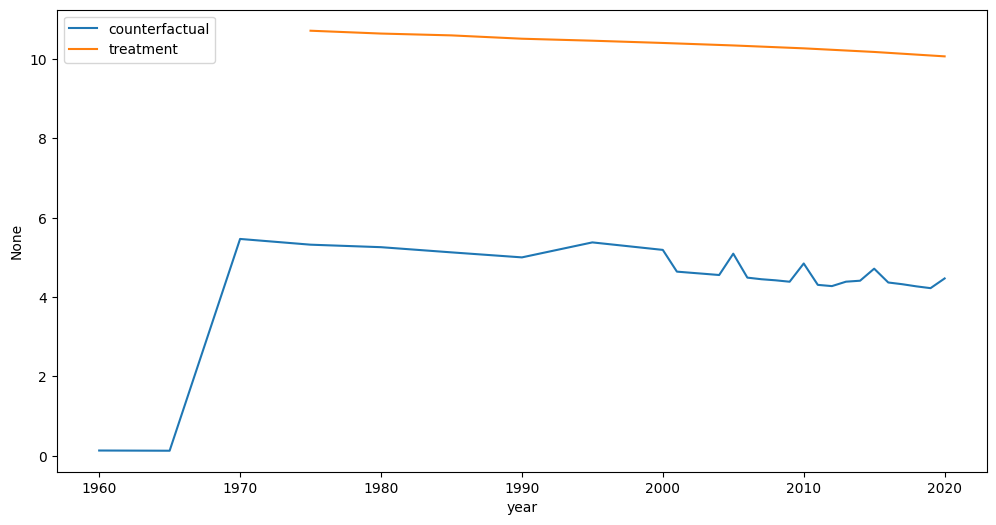

[0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.3264 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065 0.0065
 0.0065 0.0065 0.0065 0.0065 0.0065]
1.0000000001228413


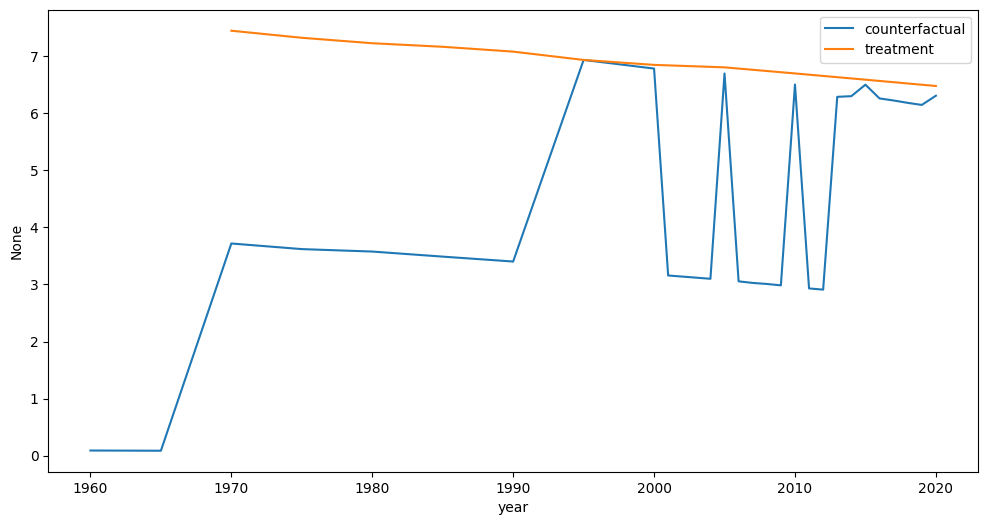

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3472 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.6528 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.    ]
1.0000000000000044


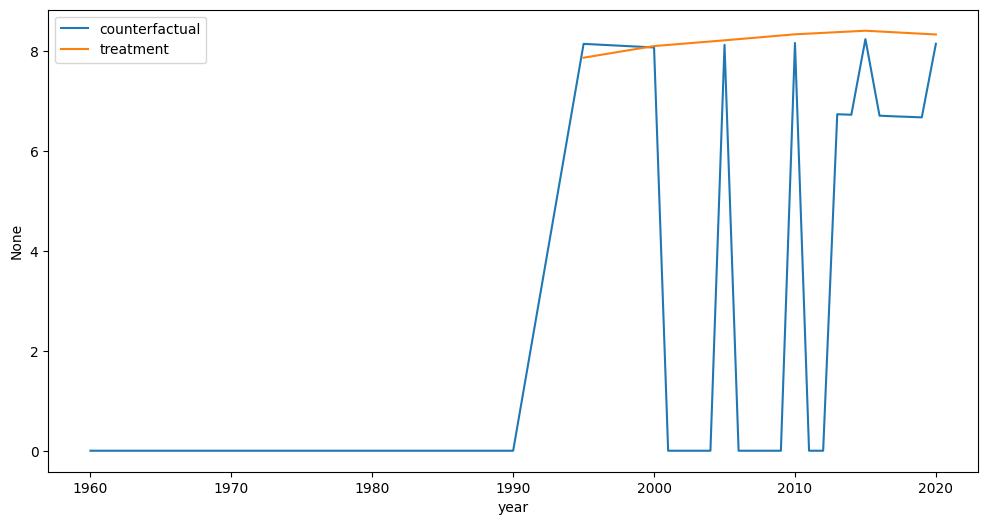

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


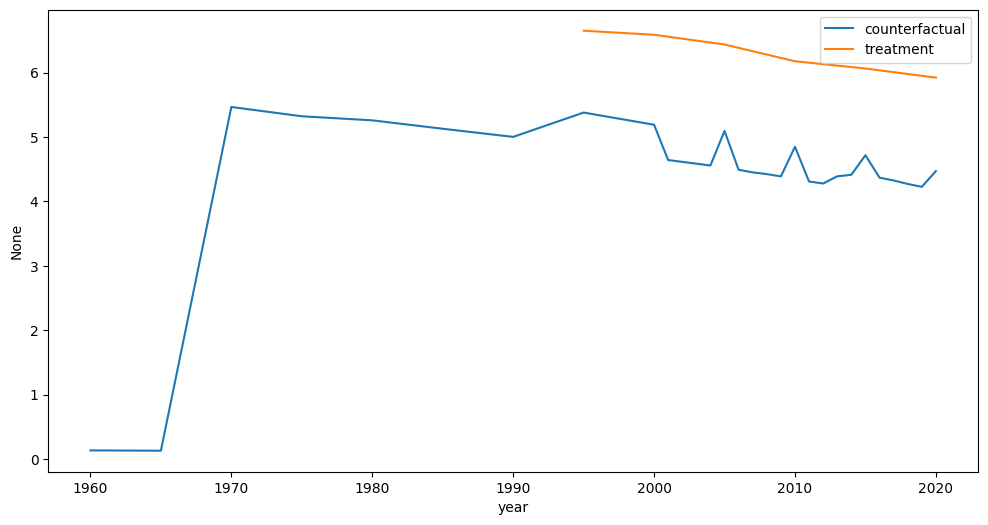

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


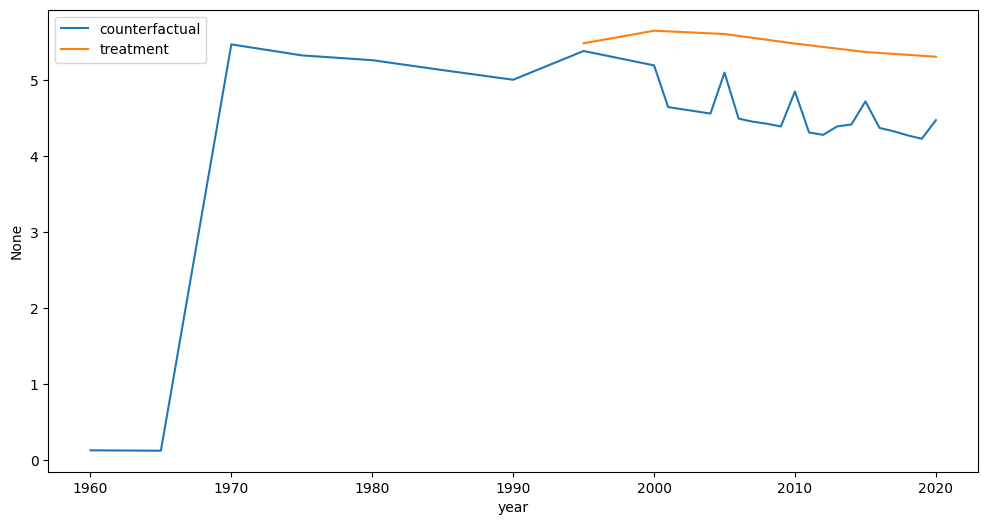

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


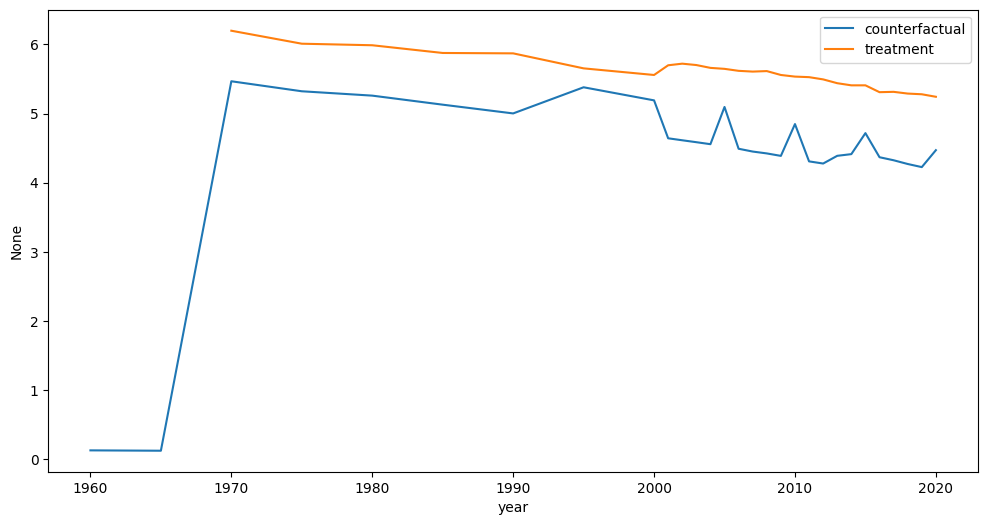

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


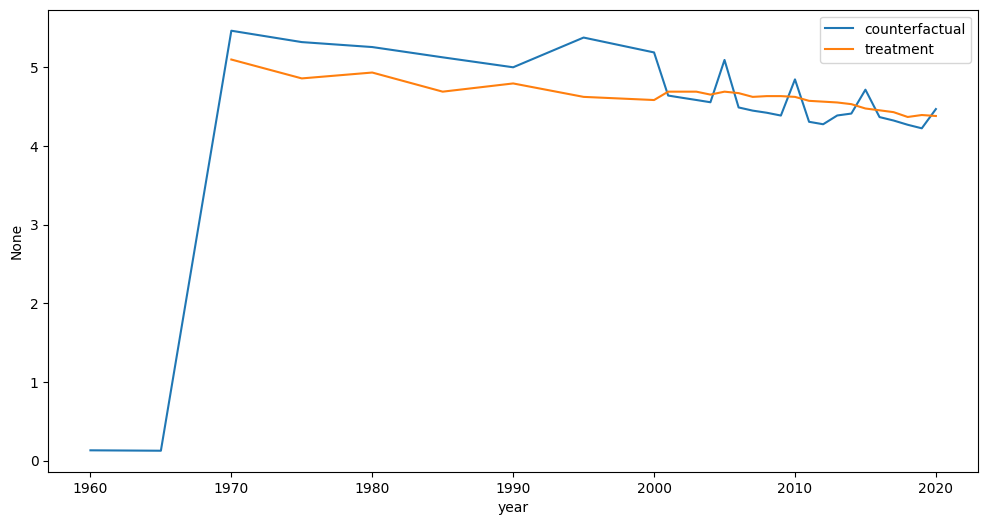

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


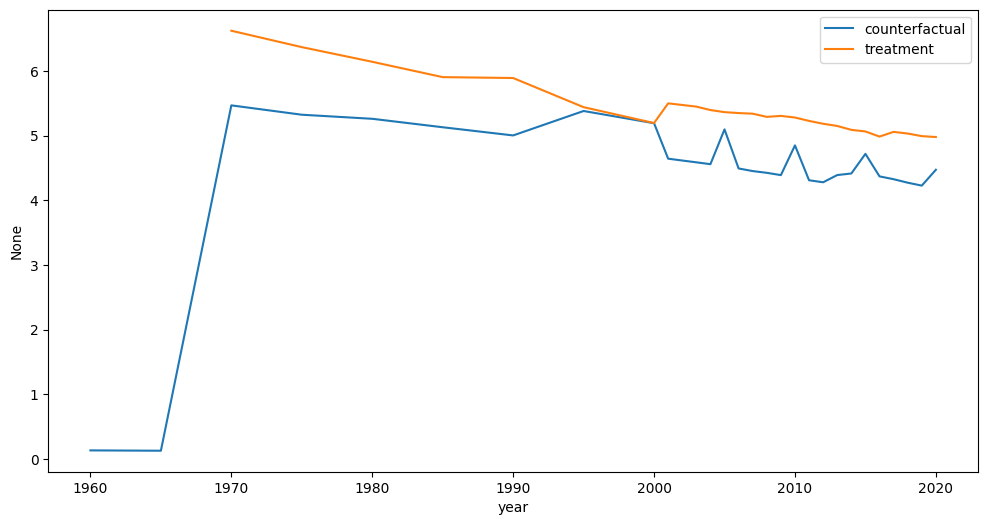

[0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.578  0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041]
1.0000000000000002


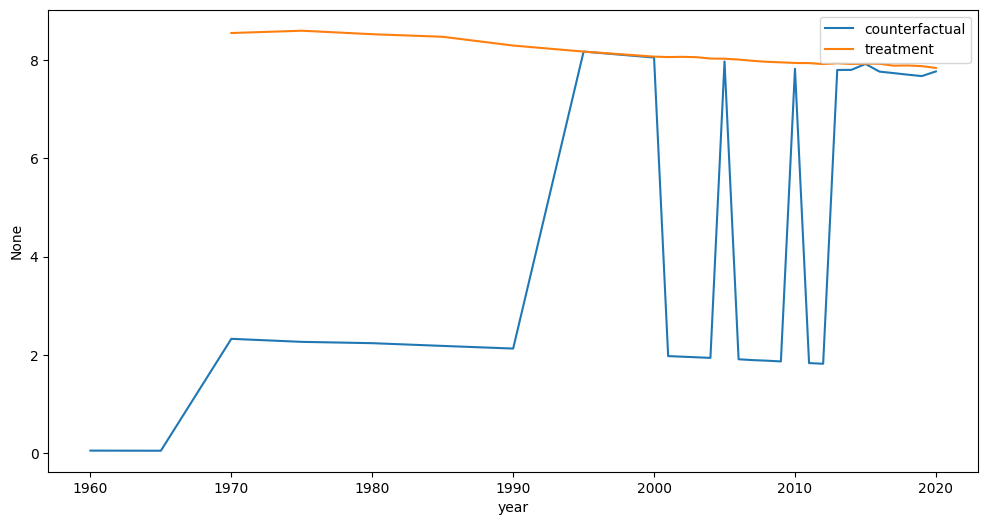

[0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.2545 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072 0.0072
 0.0072 0.0072 0.0072 0.0072 0.0072]
1.000000000054384


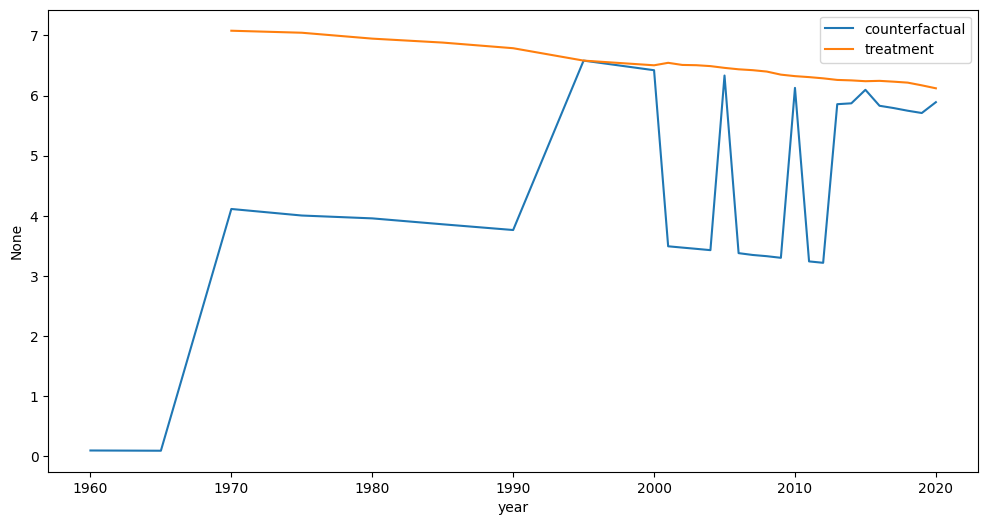

[0.0073 0.0061 0.0067 0.0075 0.0083 0.0049 0.     0.0022 0.007  0.
 0.0083 0.0025 0.0045 0.     0.0013 0.0112 0.0023 0.0016 0.0068 0.0034
 0.0039 0.0046 0.0017 0.     0.0018 0.0059 0.0051 0.0049 0.003  0.
 0.0039 0.0138 0.0035 0.0074 0.007  0.0056 0.0023 0.0068 0.     0.0095
 0.0068 0.004  0.0017 0.0035 0.0178 0.0068 0.0011 0.0036 0.0062 0.003
 0.001  0.007  0.0026 0.0027 0.0068 0.0046 0.0028 0.4923 0.0057 0.0192
 0.0053 0.0048 0.0095 0.     0.0178 0.0071 0.001  0.     0.0052 0.0005
 0.0019 0.0022 0.001  0.0056 0.0008 0.0026 0.     0.0038 0.0062 0.0126
 0.0069 0.0041 0.0021 0.0028 0.0047 0.0033 0.0095 0.0016 0.0012 0.0025
 0.0169 0.0062 0.0058 0.0047 0.0052 0.0057 0.0048 0.0026 0.0033 0.0086
 0.0076 0.0084 0.     0.0015 0.0099]
1.0


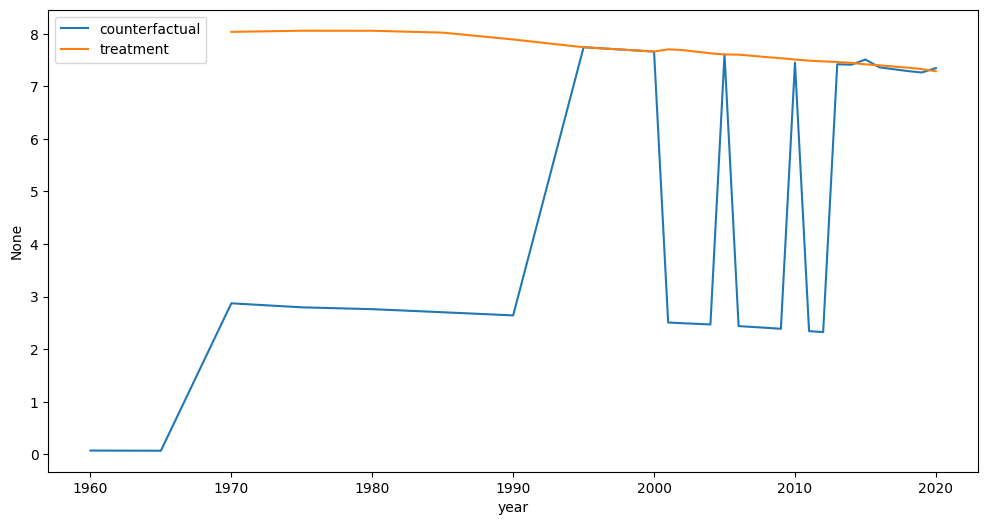

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


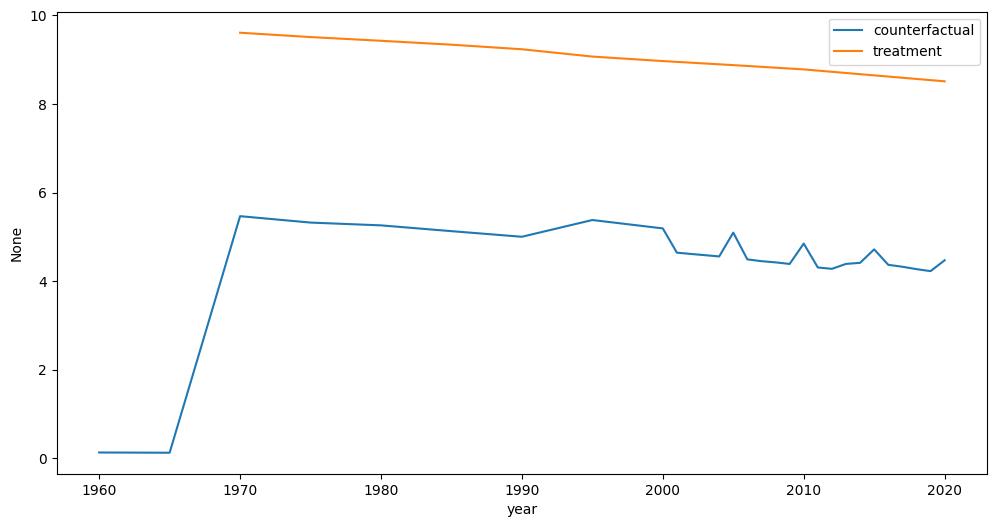

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


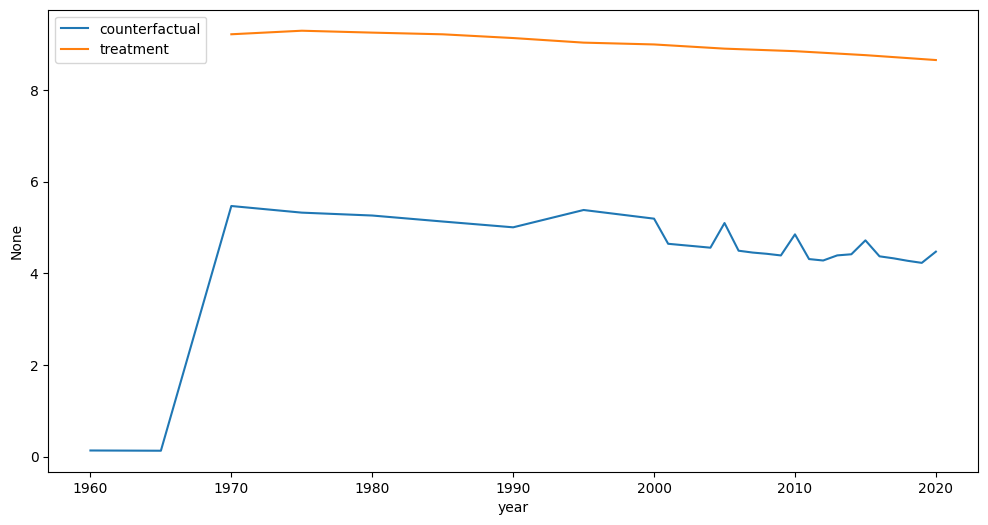

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


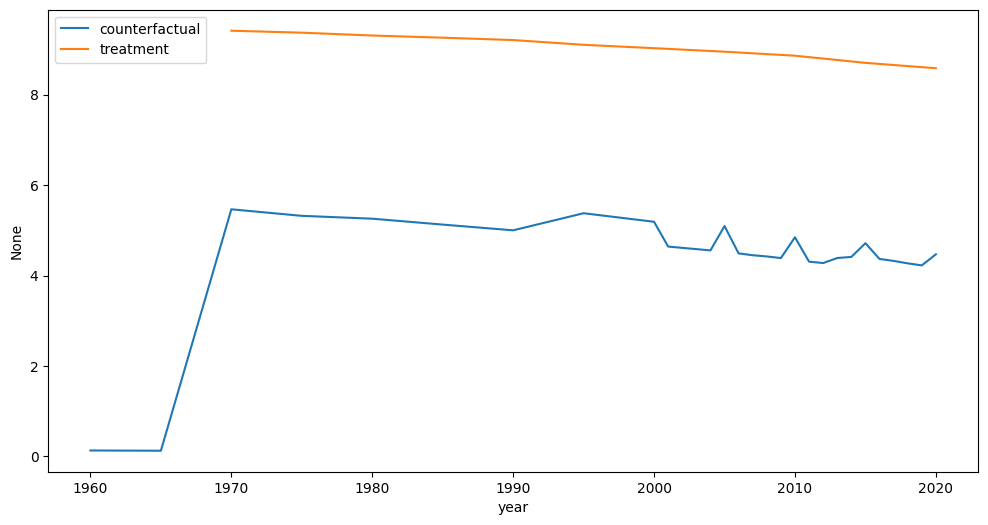

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


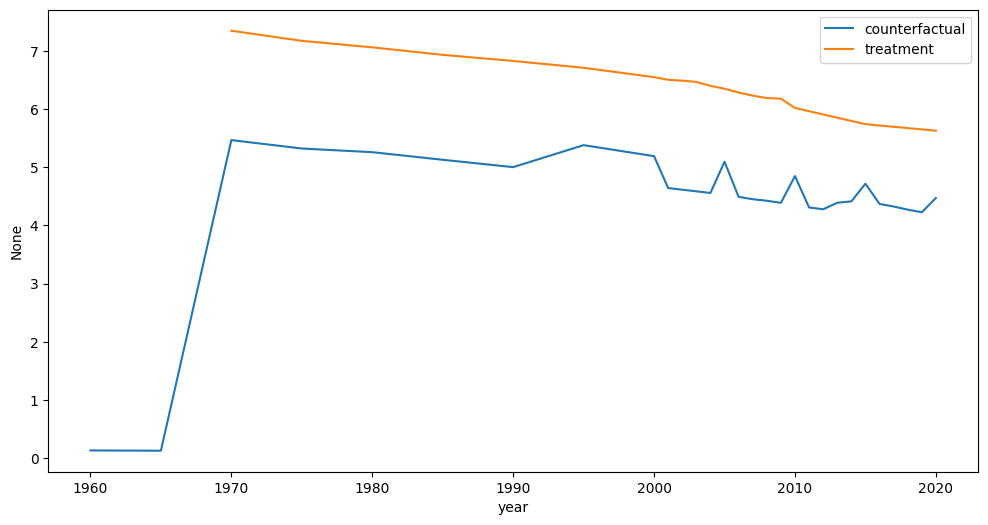

[0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.5746 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041 0.0041
 0.0041 0.0041 0.0041 0.0041 0.0041]
1.0000000057290432


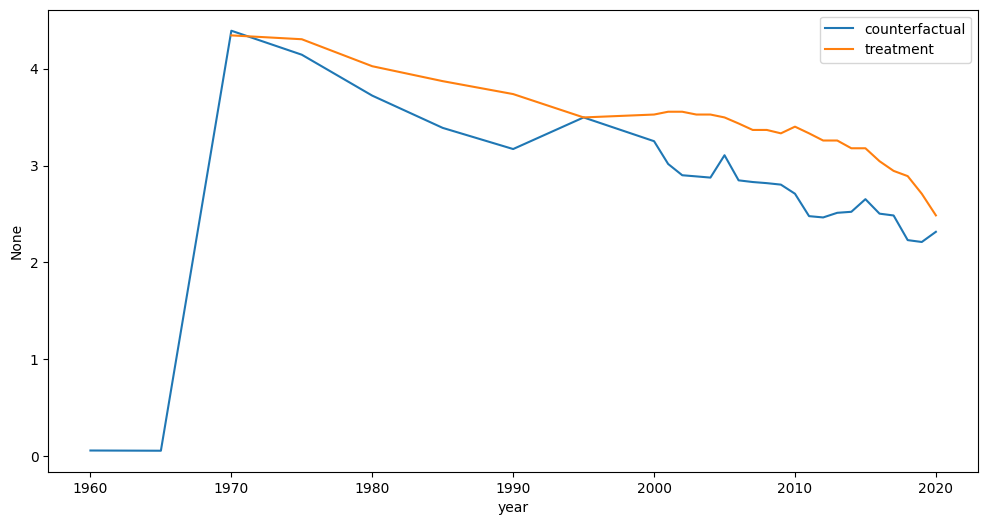

[0.0683 0.     0.     0.     0.     0.     0.     0.     0.     0.1472
 0.     0.     0.     0.1177 0.     0.     0.0609 0.     0.0162 0.
 0.     0.     0.     0.     0.     0.     0.058  0.     0.     0.0237
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0006 0.     0.
 0.     0.     0.     0.0395 0.     0.     0.     0.3212 0.     0.
 0.     0.     0.     0.     0.     0.     0.0665 0.     0.     0.
 0.0159 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0608 0.     0.     0.     0.     0.     0.
 0.     0.     0.0035 0.     0.    ]
1.0000000000000002


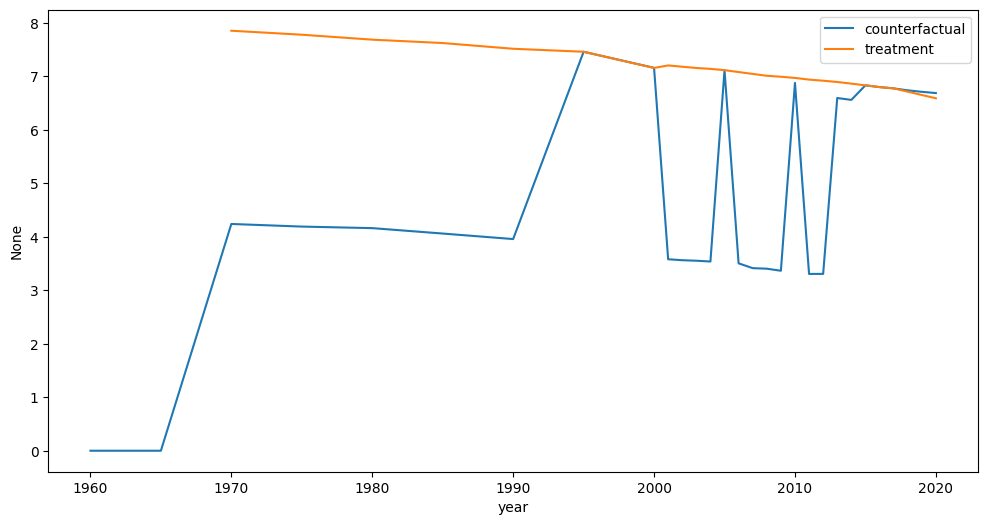

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


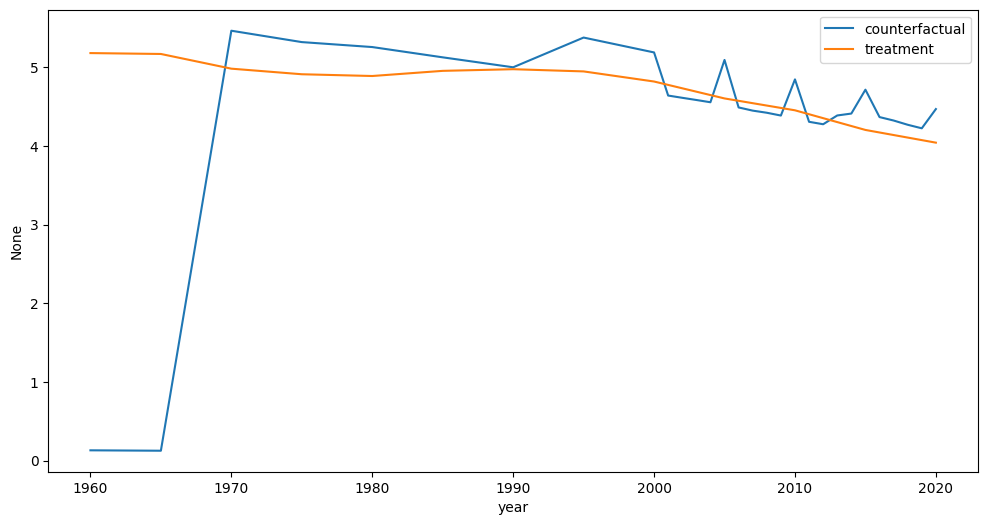

[0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095 0.0095
 0.0095 0.0095 0.0095 0.0095 0.0095]
0.9999999999999998


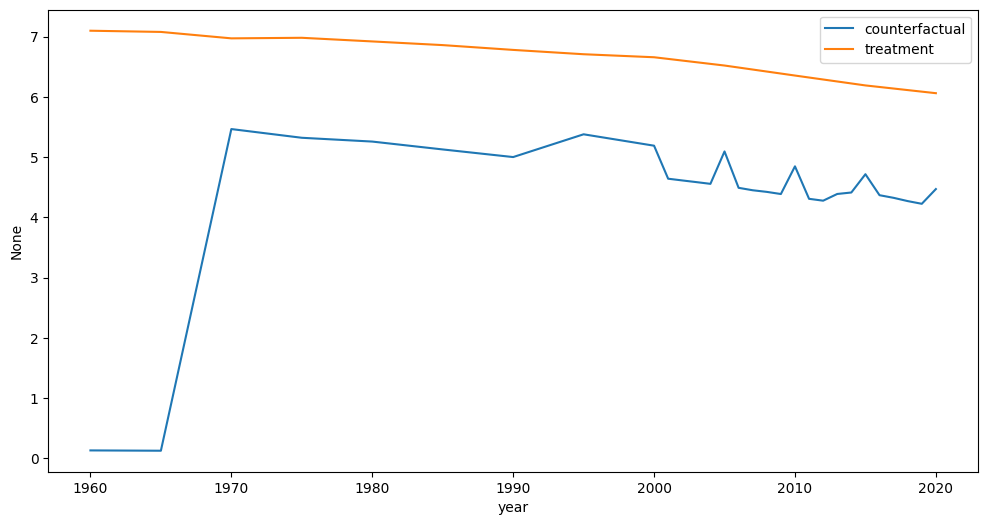

In [ ]:
treatment_island_ids = pre_treat.columns

for treatment_island_id in treatment_island_ids:
    y = pre_treat[f'{treatment_island_id}']
    X = control_df

    T = len(control_df.index.unique()) # 観測された時間の長さ
    N = control_df.columns.nunique() # control unitの数


    # MSE(平均二乗誤差)を損失関数として、その最小化をする
    def loss_function(w, X, y):
        return np.mean((y - X @ w)**2)

    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )
    bounds = [(0, None) for i in range(N)]

    alpha_init = np.ones(N) / N
    scm = minimize(
        loss_function,
        x0=alpha_init,
        args=(X, y),
        constraints=cons,
        bounds=bounds,
        method="SLSQP"
    )
    alpha_scm = scm.x
    print(alpha_scm.round(4))
    print(alpha_scm.sum())

    y_hat = np.sum(alpha_scm.T * X, axis=1)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=control_df.index, y=y_hat, label='counterfactual')
    # sns.lineplot(x=pre_treat.index, y=pre_treat[f'{treatment_island_id}'], label='pre')
    sns.lineplot(x=all_treat.index, y=all_treat[f'{treatment_island_id}'], label='treatment')
    plt.show()